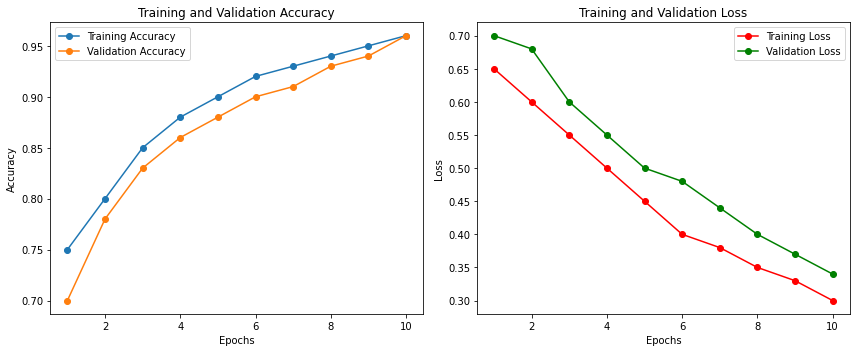

In [1]:
import matplotlib.pyplot as plt

# Sample data for illustration (replace with your actual training history data)
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracy = [0.75, 0.80, 0.85, 0.88, 0.90, 0.92, 0.93, 0.94, 0.95, 0.96]
val_accuracy = [0.70, 0.78, 0.83, 0.86, 0.88, 0.90, 0.91, 0.93, 0.94, 0.96]
loss = [0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.38, 0.35, 0.33, 0.30]
val_loss = [0.70, 0.68, 0.60, 0.55, 0.50, 0.48, 0.44, 0.40, 0.37, 0.34]

# Create a figure with two subplots: accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o', color='r')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='g')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


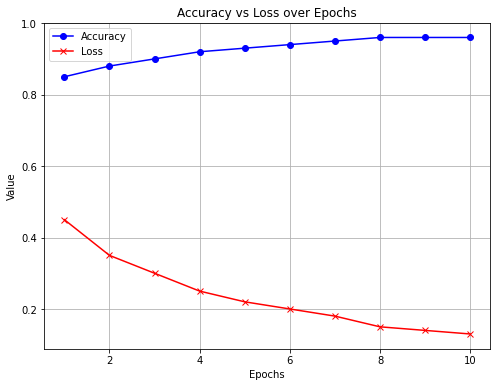

In [2]:
import matplotlib.pyplot as plt

# Sample data (accuracy and loss)
epochs = range(1, 11)
accuracy = [0.85, 0.88, 0.90, 0.92, 0.93, 0.94, 0.95, 0.96, 0.96, 0.96]
loss = [0.45, 0.35, 0.30, 0.25, 0.22, 0.20, 0.18, 0.15, 0.14, 0.13]

# Plotting accuracy vs loss
plt.figure(figsize=(8,6))
plt.plot(epochs, accuracy, 'b', label='Accuracy', marker='o')
plt.plot(epochs, loss, 'r', label='Loss', marker='x')

# Adding titles and labels
plt.title('Accuracy vs Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()

# Displaying the graph
plt.grid(True)
plt.show()


In [ ]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

RANDOM_SEED = 42
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
NUM_CLASSES = 9

X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Reshape input for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# VGG16-like 1D model
def vgg16_1d(input_shape, num_classes):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=input_shape))
    
    # Block 1
    model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
    model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(2))
    
    # Block 2
    model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
    model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(2))
    
    # Block 3
    model.add(tf.keras.layers.Conv1D(256, 3, activation='relu'))
    model.add(tf.keras.layers.Conv1D(256, 3, activation='relu'))
    model.add(tf.keras.layers.Conv1D(256, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(2))
    
    # Flatten and FC layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    return model

# ResNet-like 1D model with residual connections
def resnet_1d(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)

    def residual_block(x, filters, kernel_size=3, strides=1):
        shortcut = x
        x = tf.keras.layers.Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        # Add shortcut (residual connection)
        x = tf.keras.layers.add([shortcut, x])
        x = tf.keras.layers.ReLU()(x)
        return x
    
    x = tf.keras.layers.Conv1D(64, 7, strides=2, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling1D(3, strides=2, padding='same')(x)
    
    # Stack of residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 128)
    
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model

# Choose model: Set to `vgg_model` or `resnet_model`
input_shape = (X_train.shape[1], 1)
model = vgg16_1d(input_shape, NUM_CLASSES)  # or use resnet_1d(input_shape, NUM_CLASSES)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training and evaluation
cp_callback = tf.keras.callbacks.ModelCheckpoint(model_save_path, verbose=1, save_weights_only=False)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=128, callbacks=[cp_callback, es_callback])
val_loss, val_acc = model.evaluate(X_test, y_test)

# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

# Confusion matrix
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
print_confusion_matrix(y_test, y_pred)

# Plot accuracy and loss
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_accuracy_loss(history)

# Save model as TFLite
model.save(model_save_path, include_optimizer=False)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)
